<a href="https://colab.research.google.com/github/9M3a1h3d9i9/RL_Bots/blob/Improved/Another_copy_of_Tower_Defense_RL_with_plot(1)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#In The Name Of GOD

#DS Presentation : by Mohammad Mahdi Shafighy

#Winter 1403

#Add a Graphic report

The code simulates a tower defense game environment and uses deep Q-Reinforcement learning to train the intelligent agent to learn how to create the best defense strategy.


In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import time

 # Definition of the game environment (TowerDefenseEnv)

The TowerDefenseEnv class defines the game environment :

#Game grid:
A two-dimensional grid measuring 10x10 that includes paths, towers, enemies, and bullets.

Number 0: Empty cell.

Number 1: Enemy path.

Number 2: Tower.

Number 3: Enemy.

Number 8: Bullet.

Number -1: Enemy eliminated.

#Path of enemy movement:
The path along which the enemies move.

#Towers:
 The player can place towers on the grid.

#Resources:
امتیاز قراردادن برج در بصورت تصادفی

 The number of initial resources for the player (for placing towers).

#Main environmental functions:

##reset:
 It resets the environment and starts a new game.
##step:
 Executes a step of the game. This function:
The agent action (adding a tower) is processed.
It manages the enemy's movement along the path.

It fires bullets from the towers and checks the impact of the bullets on the enemies.

Calculates the reward.

#render:
prints the current state of the network.

In [2]:
class TowerDefenseEnv:
    def __init__(self, grid_size=(10, 10), max_steps=50):
        self.grid_size = grid_size
        self.max_steps = max_steps

        self.reset()

    def reset(self):
        # 0: Empty, 1: Path, 2: Tower, 3: Enemy, *: Bullet
        self.grid = np.zeros(self.grid_size, dtype=int)
        # Define an updated enemies path
        self.grid[2, 0:5] = 1  # Horizontal part of the path
        self.grid[2:7, 4] = 1  # Vertical part of the path
        self.grid[6, 4:9] = 1  # Horizontal part to the right
        self.enemy_position = [2, 0]  # Enemy starts at the beginning of the path
        self.towers = []  # List of tower positions
        self.bullets = []  # List of bullets fired by towers
        self.resources = 10  # Starting resources
        self.step_count = 0
        self.total_reward = 0
        return self.grid.copy()

    def step(self, action):
        """Take an action and return the new state,
         reward,
          and done flag."""
        reward = 0
        done = False

        # Action: Place tower if resources are sufficient
        if action < self.grid_size[0] * self.grid_size[1]:
            x, y = divmod(action, self.grid_size[1])
            if self.grid[x, y] == 0 and self.resources >= 5:
                self.grid[x, y] = 2  # Place a tower
                self.towers.append((x, y))
                self.resources -= 5

        # Move enemy along the path
        if self.grid[tuple(self.enemy_position)] == 3:
            self.grid[tuple(self.enemy_position)] = 1  # Clear previous position

        if self.enemy_position[1] < 4:
            self.enemy_position[1] += 1  # Horizontal path to the right
        elif self.enemy_position[0] < 6:
            self.enemy_position[0] += 1  # Vertical path downward
        elif self.enemy_position[1] < 8:
            self.enemy_position[1] += 1  # Horizontal path to the right
        else:
            done = True  # Enemy reached the end of the path
            reward = -10

        self.grid[tuple(self.enemy_position)] = 3  # Update enemy position

        # Towers shoot bullets
        for tower in self.towers:
            tower_x, tower_y = tower
            if abs(tower_x - self.enemy_position[0]) + abs(tower_y - self.enemy_position[1]) <= 2:
                # If enemy is within range, fire bullet (with damage value)
                bullet = (tower_x, tower_y, self.enemy_position, 8)  # Store bullet starting position and target
                self.bullets.append(bullet)

        # Move bullets
        new_bullets = []
        for bullet in self.bullets:
            bullet_x, bullet_y, target, damage = bullet
            # Move bullet in the direction of the target
            if bullet_x < target[0]:
                bullet_x += 1
            elif bullet_x > target[0]:
                bullet_x -= 1
            if bullet_y < target[1]:
                bullet_y += 1
            elif bullet_y > target[1]:
                bullet_y -= 1

            # Check if bullet hits enemy
            if (bullet_x, bullet_y) == tuple(target):
                reward += damage
                self.grid[bullet_x, bullet_y] = 1  # Bullet hits enemy (replacing enemy with path)
                self.enemy_position = [-1, -1]  # Remove enemy
                self.grid[bullet_x, bullet_y] = -1  # Destroy the enemy (replace bullet with -1) # Changed line
                done = True
            else:
                new_bullets.append((bullet_x, bullet_y, target, damage))  # Keep bullet if not hit

            # Place bullet on grid
            if self.grid[bullet_x, bullet_y] == 0:  # Ensure bullets are placed only on empty cells
                self.grid[bullet_x, bullet_y] = '8'  # Bullet represented as *

        self.bullets = new_bullets

        self.step_count += 1
        self.total_reward += reward
        if self.step_count >= self.max_steps:
            done = True

        return self.grid.copy(), reward, done

    def render(self):
        print("Current Grid State:")
        for row in self.grid:
            rendered_row = []  # Store rendered characters for the current row
            for cell in row:
                if cell == 0:
                    rendered_row.append('.')  # Empty cell
                elif cell == 1:
                    rendered_row.append('P')  # Path
                elif cell == 2:
                    rendered_row.append('T')  # Tower
                elif cell == 3:
                    rendered_row.append('E')  # Enemy
                elif cell == -1:
                    rendered_row.append('X') # Destroyed Enemy
                elif cell == '*':  # Check for bullet  # Add this condition
                    rendered_row.append('*')  # Bullet representation
                else:
                    rendered_row.append(str(cell))  # Other values
            print(" ".join(rendered_row))
        print("\n")

#Definition of the agent (DQNAgent)
The DQNAgent class defines an intelligent agent that uses the Deep Q-Network (DQN) algorithm.


##Main components of the agent:

###Neural network model:
####Input:
 Environment state *(flattened)*.
####Output:
 The Q value for each possible action.
####Architecture:
 It includes Dense layers with *ReLU activation*.

##Action selection strategy:
###Exploration:
 Chooses a random action with **probability ε**.
###Exploitation:
 It selects the action that has the **highest Q value**.
#Learning:
####It uses the **Experience Replay method** for learning.

####It updates the estimated **future reward using the Q value**.

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    ### Improvment
    def _build_model(self):
        model = Sequential()
        # model.add(Flatten(input_shape=(self.state_size,)))     --> Del

          ### Define shape_input by Input hleps
        model.add(tf.keras.Input(shape=(self.state_size,)))  ###
          ### Del 'input_shape' from 'Flatten'
        model.add(Flatten())   ###

        model.add(Dense(24, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            action = random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state, verbose=0)
            action = np.argmax(q_values[0])
        return action

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

#Training the agent (train_tower_defense)
This function trains the agent in the environment:


###The game is played in several episodes (here, 500 episodes).
####In each episode, the agent **observes the state of the environment** and **takes action based on its model**.

#####After each episode, the **total reward** is *stored*, and the `agent replays experiences` `from memory` **to improve its model**.
The agent's performance during the episodes is plotted on a graph.

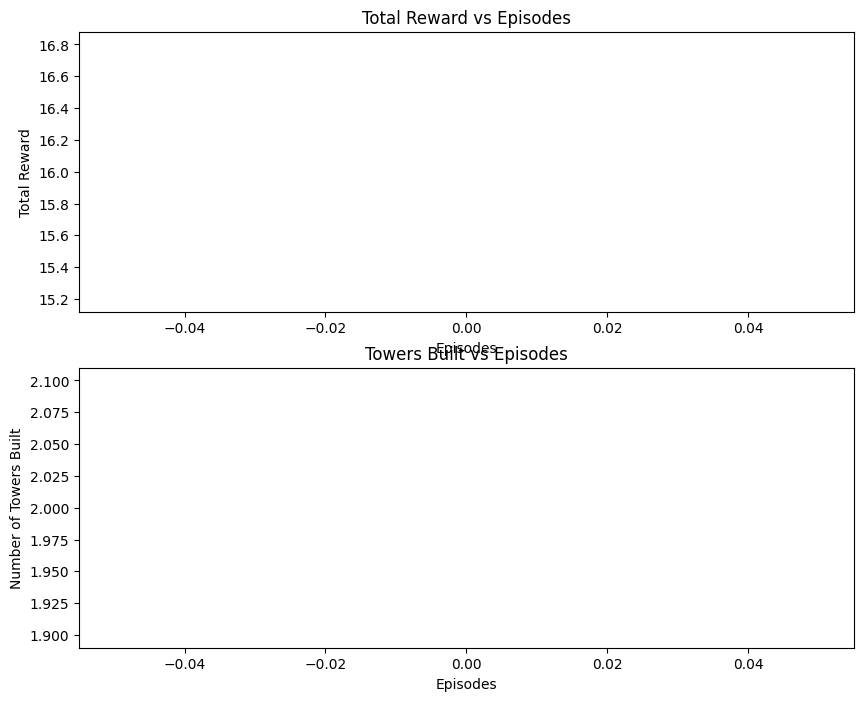

In [5]:
### Update in train_tower_defense function to save and draw graphs
def train_tower_defense():
    env = TowerDefenseEnv()
    state_size = env.grid_size[0] * env.grid_size[1]
    action_size = state_size  # Each cell is a potential action
    agent = DQNAgent(state_size, action_size)
    episodes = 50
    batch_size = 32

    scores = []
      ### Saving the number of towers per episode
    towers_built = []
    plt.ion()  # Enable interactive mode for dynamic plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.set_title("Total Reward vs Episodes")
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Total Reward")
    ax2.set_title("Towers Built vs Episodes")
    ax2.set_xlabel("Episodes")
    ax2.set_ylabel("Number of Towers Built")

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        total_reward = 0
        towers_count = 0  ### Count the number of towers
        for time in range(env.max_steps):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            ### Count towers
            towers_count = len(env.towers)

            if done:
                break

        scores.append(total_reward)
        towers_built.append(towers_count)

        # Updating Plot
        ax1.clear()
        ax1.plot(scores, color='blue')
        ax1.set_title("Total Reward vs Episodes")
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Total Reward")

        ax2.clear()
        ax2.plot(towers_built, color='green')
        ax2.set_title("Towers Built vs Episodes")
        ax2.set_xlabel("Episodes")
        ax2.set_ylabel("Number of Towers Built")

        plt.pause(0.01)

        agent.replay(batch_size)

    plt.ioff()
    plt.show()


if __name__ == "__main__":
    train_tower_defense()

In [6]:
from IPython.display import display, clear_output

def train_tower_defense():
    env = TowerDefenseEnv()
    state_size = env.grid_size[0] * env.grid_size[1]
    action_size = state_size  # Each cell is a potential action
    agent = DQNAgent(state_size, action_size)
    episodes = 500
    batch_size = 32

    scores = []
    towers_built = []

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        total_reward = 0
        towers_count = 0
        for time in range(env.max_steps):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            towers_count = len(env.towers)

            if done:
                break

        scores.append(total_reward)
        towers_built.append(towers_count)

        # Updating Plot
        clear_output(wait=True)  # Clear previous output

        ax1.clear()
        ax1.plot(scores, color='blue')
        ax1.set_title("Total Reward vs Episodes")
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Total Reward")

        ax2.clear()
        ax2.plot(towers_built, color='green')
        ax2.set_title("Towers Built vs Episodes")
        ax2.set_xlabel("Episodes")
        ax2.set_ylabel("Number of Towers Built")

        display(fig)            # Display the updated figure
        plt.pause(0.1)       # Pause to allow the plot to update

        agent.replay(batch_size)

    plt.show() # Show the final plot outside the loop

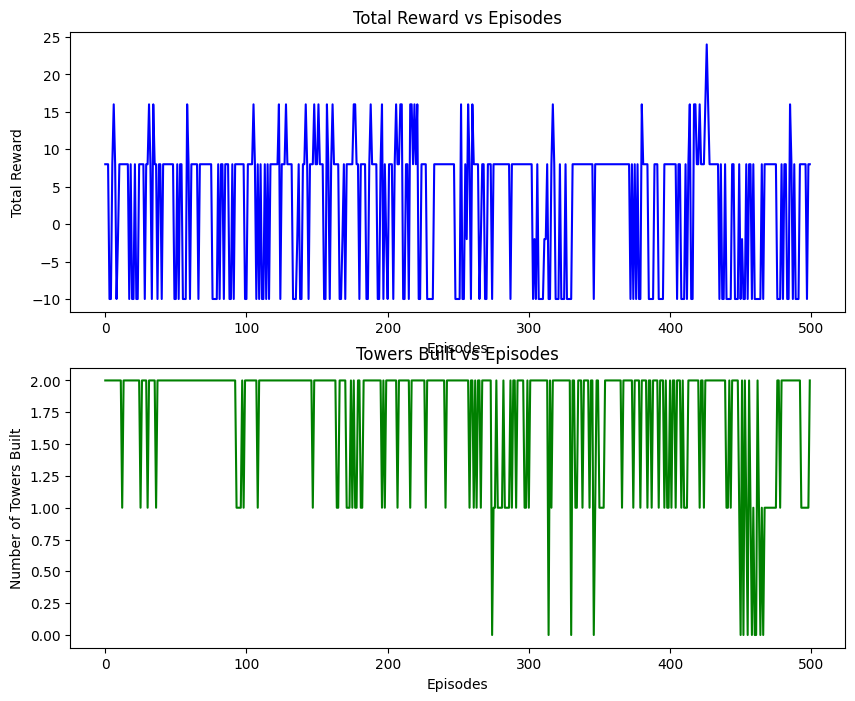

In [7]:
if __name__ == "__main__":
    train_tower_defense()